In [163]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

import hashlib

plt.style.use('ggplot')

# 1. Датасет
Рассмотрим датасет с данными о бронировании авиабилетов.

Каждая строка датасета соответствует отдельному бронированию и описывается рядом признаков:

- `booking_id` - ID бронирования
- `booking_month` - месяц покупки билета
- `passengers` - количество пассажиров в бронировании
- `price` - стоимость покупки билета. Причём если пассажиров несколько, то это поле учитывает полную стоимость, а не на 1 пассажира
- `flights_info` - список из всех рейсов в этом билете. Считаем, что это все рейсы без обратного билета, но по пути могут быть пересадки. Элемент списка - конкретный перелёт. Выглядит этот список например так
```
[
    {
        "origin": "SVO",
        "destination": "MCT",
        "airline": "WY",
        "baggage": "With baggage"
    },
    {
        "origin": "MCT",
        "destination": "HKT",
        "airline": "WY",
        "baggage": "With baggage"
    }
]
```

In [93]:
df = pd.read_csv('data.csv', encoding='cp1251')
df.head()

,booking_id,booking_month,passengers,price,flights_info
0,ad0fcf37ea1c73bdb99bca7ee0d354d6,8,1,5975,"[{""origin"": ""SVO"", ""destination"": ""LED"", ""airl..."
1,260007a493745066beff4f4f3d9f8b3d,5,1,2460,"[{""origin"": ""VKO"", ""destination"": ""LED"", ""airl..."
2,c053027254b479399c68c1e2b583e8a4,4,1,8057,"[{""origin"": ""DME"", ""destination"": ""LED"", ""airl..."
3,330e2266c62e6f133a9e12aa926c330d,4,1,5649,"[{""origin"": ""VKO"", ""destination"": ""LED"", ""airl..."
4,d18be595cfef37f26a0085f3b720a032,6,1,4627,"[{""origin"": ""DME"", ""destination"": ""LED"", ""airl..."


посмотрим на информацию о датасете

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135508 entries, 0 to 135507
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   booking_id     135508 non-null  object
 1   booking_month  135508 non-null  int64 
 2   passengers     135508 non-null  int64 
 3   price          135508 non-null  int64 
 4   flights_info   135508 non-null  object
dtypes: int64(3), object(2)
memory usage: 5.2+ MB


посмотрим все ли хорошо с данными, в каких диапазонах лежат численные признаки

In [28]:
df.describe()

,booking_month,passengers,price
count,135508.000000,135508.000000,135508.000000
mean,5.021637,1.275032,7318.693413
std,2.213675,0.607968,12557.895003
min,1.000000,1.000000,100.000000
25%,3.000000,1.000000,2974.000000
50%,5.000000,1.000000,4468.000000
75%,7.000000,1.000000,6877.000000
max,8.000000,9.000000,840294.000000


проверим что поле `booking_id` уникально

In [13]:
df.groupby('booking_id').agg('count').sort_values('booking_month').head(5)

,booking_month,passengers,price,flights_info
booking_id,,,,
fffdf76aa2a32eda3a8d45ea2558a4e8,1,1,1,1
fffdd6a5dd32b5986651bdc2bbf7263d,1,1,1,1
fffdb7e6ff4eb2d48a176dc5a7c68b41,1,1,1,1
fffd60d00ae0a7ac57df2d0ef27a3c39,1,1,1,1
fffd39b87bd9b44574bb15dbf523096e,1,1,1,1


посмотрим на гистограммы для численных признаков. визуально с данными все в порядке и дополнительно отчищать их не стоит

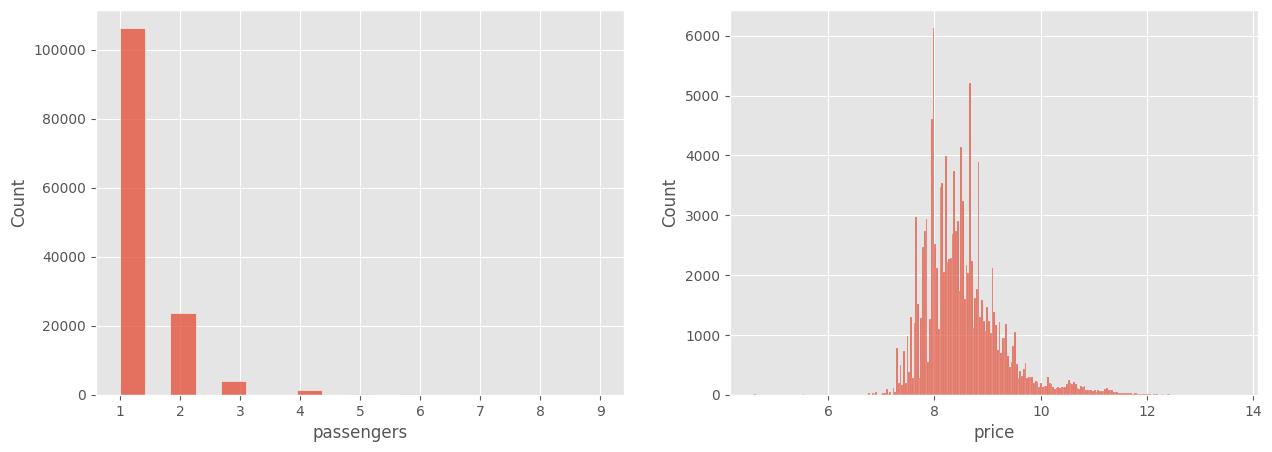

In [26]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(df['passengers'], ax=ax1)
sns.histplot(np.log(df['price']), ax=ax2);

# Преобразование к данным о рейсах

Хотелось бы привести данные в такой вид, чтобы на каждый рейс внутри билета была своя отдельная строка. То есть в примере выше этот один билет должен породить 2 строки с рейсом `SVO->MCT` и `MCT->HKT`

в новой табличке будут следующие столбцы
- `booking_id` - ID бронирования
- `booking_month` - месяц покупки билета
- `itinerary` - маршрут, должен иметь вид `{start airport}-{change airport 1}-...-{change airport N}-{finish airport}`. Для примера выше это будет строка `SVO-MCT-HKT`
- `flights_count` - количество рейсов в маршруте (1, если рейс прямой, и больше 1, если есть хотя бы одна пересадка)
- `flight_id` - ID рейса (можно сгенерировать как хэш функция `md5` от `booking_id` + дополнительный символ (например, можно использовать `flight_index`, описанный ниже))
- `flight_index` - номер рейса в маршруте, начиная с 0. То есть для примера выше рейс `SVO->MCT` имеет индекс `0`, а `MCT->HKT` имеет индекс 1
- `origin` - код аэропорта вылета рейса
- `destination` - код аэропорта прилёта рейса
- `airline` - код авиакомпании, выполняющий рейс
- `baggage` - информаиция о том, является ли тариф билета с багажом или без багажа
- `passengers` - количество пассажиров в билете
- `price` - цена билета (полная)

В некоторых данных о бронировании присутствовали пропуски, они были заменены на текстовое значение `None`

In [196]:
def transform_bookings_to_flights(df_bookings: pd.DataFrame) -> pd.DataFrame:
    '''
    Преобразует данные бронированиях в данные о рейсах.

    Параметры:
    df_bookings : pd.DataFrame
        данными о бронированиях
        - booking_id (str): ID бронирования.
        - booking_month (str): Месяц покупки билета.
        - passengers (int): Количество пассажиров.
        - price (float): Общая стоимость бронирования.
        - flights_info (list of dict): Список словарей с данными по каждому рейсу.

    Возвращает:
    pd.DataFrame
        данные о рейсах
        - booking_id (str): ID бронирования.
        - booking_month (str): Месяц покупки билета.
        ***********************************************************
        - itinerary (str): Полный маршрут (например, 'SVO-MCT-HKT').
        - flights_count (int): Общее количество рейсов в маршруте.
        - flight_id (str): Уникальный ID рейса (MD5 хэш).
        - flight_index (int): Порядковый номер рейса в маршруте (начиная с 0).
        - origin (str): Код аэропорта вылета рейса.
        - destination (str): Код аэропорта прилёта рейса.
        - airline (str): Код авиакомпании, выполняющий рейс.
        - baggage (str): Информация о багаже ('With baggage' / 'Without baggage').
        ***********************************************************
        - passangers (int): Количество пассажиров.
        - price (float): Цена билета.
    '''
    flights_data = []
    # итерируемся построчно по табличке с бронированиями
    for index, row in df_bookings.iterrows():

      flights_info = eval(row['flights_info'])
      # Извлечение полей рейса
      booking_id = row['booking_id']
      booking_month = row['booking_month']
      initianery = flights_info[0].get('origin', 'None')+'-'+'-'.join([flight_dict.get('destination', 'None') for flight_dict in flights_info])
      flights_count = len(flights_info)
      passengers = row['passengers']
      price = row['price']

      # Итерация по каждому рейсу в бронировании
      for flight_index, flight_dict in enumerate(flights_info):
          # Генерация flight_id с помиощью md5
          flight_id = booking_id+str(flight_index)
          flight_id = hashlib.md5(flight_id.encode()).hexdigest()

          origin = flight_dict.get('origin', 'None')
          destination = flight_dict.get('destination', 'None')
          airline = flight_dict.get('airline', 'None')
          baggage = flight_dict.get('baggage', 'None')
          # словарь c полями для каждого рейса
          temp = {
              'booking_id': booking_id,
              'booking_month': booking_month,
              'itinerary': initianery,
              'flights_count': flights_count,
              'flight_id': flight_id,
              'flight_index': flight_index,
              'origin': origin,
              'destination': destination,
              'airline': airline,
              'baggage': baggage,
              'passengers': passengers,
              'price': price
          }
          flights_data.append(temp)
    df_flights = pd.DataFrame(flights_data)
    return df_flights

In [197]:
transform_bookings_to_flights(df_bookings=df)

,booking_id,booking_month,itinerary,flights_count,flight_id,flight_index,origin,destination,airline,baggage,passengers,price
0,ad0fcf37ea1c73bdb99bca7ee0d354d6,8,SVO-LED,1,fea9a98aebc94adfef94e92e95182ffe,0,SVO,LED,FV,No baggage,1,5975
1,260007a493745066beff4f4f3d9f8b3d,5,VKO-LED,1,c07155934b24cb7e38e557870c424b53,0,VKO,LED,FV,No baggage,1,2460
2,c053027254b479399c68c1e2b583e8a4,4,DME-LED,1,ba4f6f457da6f09149d54aa2f00e401a,0,DME,LED,S7,No baggage,1,8057
3,330e2266c62e6f133a9e12aa926c330d,4,VKO-LED,1,687eed0c0972312a1247db118c937e1f,0,VKO,LED,FV,No baggage,1,5649
4,d18be595cfef37f26a0085f3b720a032,6,DME-LED,1,dd9b915c664d60ac8733b3a897245b4f,0,DME,LED,U6,No baggage,1,4627
...,...,...,...,...,...,...,...,...,...,...,...,...
137077,9ae4043201604be66fc6e82722d4d6a4,7,SVO-HKT,1,d0cfbae757f6328329fd1c52ed75b01a,0,SVO,HKT,SU,With baggage,1,70502
137078,681d48f6c8d79769db985fa2ca808196,2,DME-LED,1,7b959e7e87fe50de8fab5764e876741d,0,DME,LED,S7,No baggage,1,5757
137079,233379d95d217fa64c3c9a9245f605b1,2,VKO-LED,1,377785a08a94f6189e7355dee5b75b92,0,VKO,LED,UT,No baggage,1,1895
137080,d16cda1e44f4b4abdce4cf33db05ece1,4,SVO-LED,1,6745554c6c2d9e99ffa4879cc0c760f7,0,SVO,LED,N4,No baggage,1,3462


чтобы убедиться в корректности работы возьмем `booking_id = 9e4fe16c6b4ef06df6e239f914b3ed12`

In [200]:
import hashlib

flights_data = []
row = df.iloc[38]
print('Исходная строка: ')
display(row)

flights_info = eval(row['flights_info'])
# Извлечение полей рейса
booking_id = row['booking_id']
booking_month = row['booking_month']
initianery = flights_info[0]['origin']+'-'+'-'.join([flight['destination'] for flight in flights_info])
flights_count = len(flights_info)
passengers = row['passengers']
price = row['price']

# Итерация по каждому рейсу в бронировании
for flight_index, flight_dict in enumerate(flights_info):
    # Генерация flight_id с помиощью md5
    flight_id = booking_id+str(flight_index)
    flight_id = hashlib.md5(flight_id.encode()).hexdigest()

    origin, destination, airline, baggage = flight_dict.values()
    # словарь c полями для каждого рейса
    temp = {
        'booking_id': booking_id,
        'booking_month': booking_month,
        'itinerary': initianery,
        'flights_count': flights_count,
        'flight_id': flight_id,
        'flight_index': flight_index,
        'origin': origin,
        'destination': destination,
        'airline': airline,
        'baggage': baggage,
        'passengers': passengers,
        'price': price
    }
    flights_data.append(temp)
print('Cтрока после преобразования: ')
pd.DataFrame(flights_data)

Исходная строка: 


,38
booking_id,9e4fe16c6b4ef06df6e239f914b3ed12
booking_month,7
passengers,1
price,36541
flights_info,"[{""origin"": ""SVO"", ""destination"": ""MCT"", ""airl..."


Cтрока после преобразования: 


,booking_id,booking_month,itinerary,flights_count,flight_id,flight_index,origin,destination,airline,baggage,passengers,price
0,9e4fe16c6b4ef06df6e239f914b3ed12,7,SVO-MCT-HKT,2,dfe0db5fe9514d9c1876db05c26a6b4e,0,SVO,MCT,WY,With baggage,1,36541
1,9e4fe16c6b4ef06df6e239f914b3ed12,7,SVO-MCT-HKT,2,742cccdf8eb29fdd74821fe30a20d1ed,1,MCT,HKT,WY,With baggage,1,36541


## BI - визуализация

Выше был получен более удобный для аналитики датасет, который можно использовать для исследований данных и визуализаций в дашбордах.

Соберем визуализацию с помощью `YandexDatalens`

### **Dashboard: Московский узел**

Из Москвы с Питер `LED` можно улететь разными способами
- Из Шереветьево `SVO`
- Из Внуково `VKO`
- Из Домодедово `DME`

Проанализируем пассажиропоток по следующим пунктам:
- Как он распределён между этими московскими аэропортами?
- Какая динамика в году по пассажиропотоку? Если есть какие-то изменения в трафике, то чем их можно объяснить?
- Конкуренция есть не только у аэропортов, но и у авиакомпаний. Как распределён трафик между ними для каждого аэропорта?
- Цены какой авиакомпании являются наиболее выгодными? Какой самый дешёвый способ улететь на самолёте из Москвы в Питер?
- Какая авиакомпания зарабатывает больше всех (в сумме и в среднем на одном пассажире)? Можно считать, что выручка авиакомпании - это сумма цен билетов

In [202]:
df_flights = transform_bookings_to_flights(df_bookings=df)

In [204]:
df_flights.index = df_flights['booking_id']
df_flights.head()

,booking_id,booking_month,itinerary,flights_count,flight_id,flight_index,origin,destination,airline,baggage,passengers,price
booking_id,,,,,,,,,,,,
ad0fcf37ea1c73bdb99bca7ee0d354d6,ad0fcf37ea1c73bdb99bca7ee0d354d6,8,SVO-LED,1,fea9a98aebc94adfef94e92e95182ffe,0,SVO,LED,FV,No baggage,1,5975
260007a493745066beff4f4f3d9f8b3d,260007a493745066beff4f4f3d9f8b3d,5,VKO-LED,1,c07155934b24cb7e38e557870c424b53,0,VKO,LED,FV,No baggage,1,2460
c053027254b479399c68c1e2b583e8a4,c053027254b479399c68c1e2b583e8a4,4,DME-LED,1,ba4f6f457da6f09149d54aa2f00e401a,0,DME,LED,S7,No baggage,1,8057
330e2266c62e6f133a9e12aa926c330d,330e2266c62e6f133a9e12aa926c330d,4,VKO-LED,1,687eed0c0972312a1247db118c937e1f,0,VKO,LED,FV,No baggage,1,5649
d18be595cfef37f26a0085f3b720a032,d18be595cfef37f26a0085f3b720a032,6,DME-LED,1,dd9b915c664d60ac8733b3a897245b4f,0,DME,LED,U6,No baggage,1,4627


In [206]:
df_flights.to_excel('aviasales_flights_data.xlsx')